In [1]:
import esmvalcore.experimental as esmvaltool
import esmvalcore.preprocessor._regrid_esmpy as _regrid_esmpy
import esmvalcore.preprocessor._regrid as _regrid

import xarray as xr
import xesmf as xe
import numpy as np

import iris

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt

/Users/dhohn/mambaforge/envs/test_env/lib/python3.9/site-packages/esmvalcore/experimental/_warnings.py:13: UserWarning: 
  Thank you for trying out the new ESMValCore API.
  Note that this API is experimental and may be subject to change.
  More info: https://github.com/ESMValGroup/ESMValCore/issues/498


# Run the recipe to have auto download

This is just an example worth about 60MB. In this model the "northpole" is moved to be over greenland. But tripolar models would present similarly in coord structure.

In [2]:
%cat recipe_download.yml

documentation:
  description: dummy
  title: dummy
  authors:
    - righi_mattia

datasets:
  - {dataset: MPI-ESM1-2-LR, project: CMIP6, exp: 1pctCO2, ensemble: r1i1p1f1, grid: gn, timerange: "1850/1870"}

diagnostics:
  download:
    description: dummy diagnostic to trigger autodownload
    variables:
      fgco2:
        mip: Omon
    scripts: null


In [3]:
recipe = esmvaltool.Recipe("recipe_download.yml")
output = recipe.run()

In [4]:
taskoutput = output["download/fgco2"]
datafile = taskoutput.data_files[0]

## Load example data as iris.Cube and xarray.DataSet

In [5]:
cube = datafile.load_iris().concatenate_cube()
xrds = datafile.load_xarray()

Define target Cube/Dataset with regular rectilinear grids

In [6]:
cube_target = _regrid._global_stock_cube("1x1") # LONxLAT

In [7]:
xrds_target = xr.Dataset(
    {
        "lat": (["lat"], np.arange(-90, 90, 1)),
        "lon": (["lon"], np.arange(0, 360, 1)),
    }
)

In [8]:
cube_target.shape

(180, 360)

In [9]:
xrds_target.dims

Frozen({'lat': 180, 'lon': 360})

## 0. First attempt with iris builtin regridding and the PointInCell scheme is not working.

I guess this is for regular curvilinear grids? Otherwise requiring a CRS doesn't make sense?

In [29]:
cube.regrid(cube_target, scheme=iris.analysis.PointInCell())

ValueError: The source X and Y coordinates must have a defined coordinate system.

# 0.1 What if we assume WGS84 like in iris.cartography.project?

In [10]:
wgs84 = iris.coord_systems.GeogCS(semi_major_axis=6378137.0, inverse_flattening=298.257223563)

In [11]:
cube.coord_system = wgs84
cube.coord(axis="x").coord_system = wgs84
cube.coord(axis="y").coord_system = wgs84

cube_target.coord_system = wgs84
cube_target.coord(axis="x").coord_system = wgs84
cube_target.coord(axis="y").coord_system = wgs84

In [12]:
cube_out = cube.regrid(cube_target, scheme=iris.analysis.PointInCell())

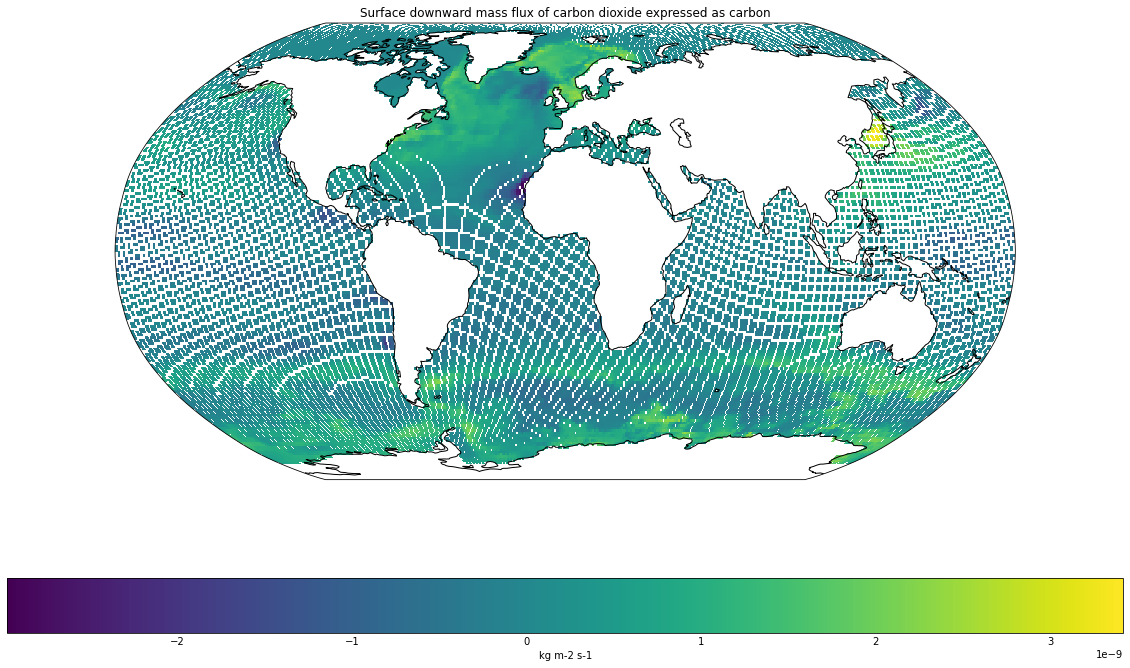

In [13]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
qplt.pcolormesh(cube_out[0])
plt.gca().coastlines()

No ;) but I guess it makes sense as there are not enough source points to the in the cell.

# 1. Builtin esmvalcore function that is also used by `regrid` preprocessor

In [14]:
cube_out = _regrid_esmpy.regrid(cube, cube_target, "linear")

In [15]:
iris.save(cube_out, "iris.nc")

### It's slow!

In [16]:
%timeit _regrid_esmpy.regrid(cube, cube_target, "linear")

11.8 s ± 209 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


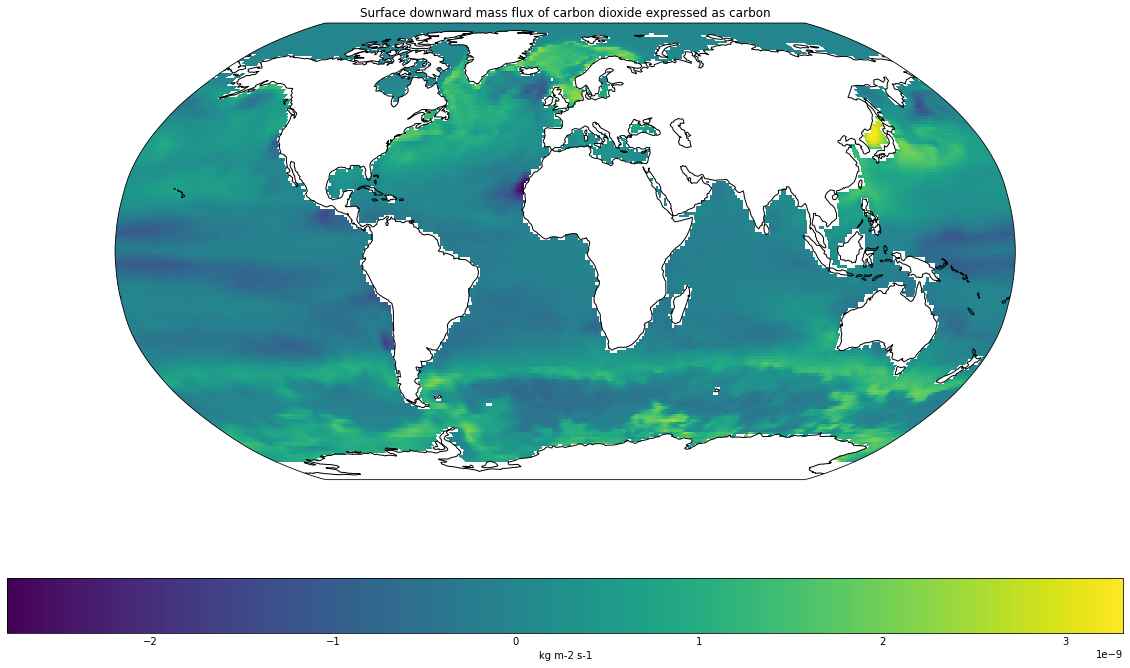

In [17]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
qplt.pcolormesh(cube_out[0])
plt.gca().coastlines()

# 2. xesmf regridding 

In [18]:
regridder = xe.Regridder(xrds, xrds_target, "bilinear", filename="weights", reuse_weights=False)

In [19]:
xrds_out = regridder(xrds)

/Users/dhohn/mambaforge/envs/test_env/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.
/Users/dhohn/mambaforge/envs/test_env/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.


In [20]:
xrds_out.to_netcdf("xr.nc")

### 60x times faster on my laptop!
I believe the reason is that xesmf only computes the weights using ESMPy, but then applies them to the data with scipy sparse matrix multiplication.

In [21]:
%%timeit
regridder = xe.Regridder(xrds, xrds_target, "bilinear", filename="weights", reuse_weights=True)
xrds_out = regridder(xrds)

/Users/dhohn/mambaforge/envs/test_env/lib/python3.9/site-packages/xesmf/smm.py:130: UserWarning: Input array is not C_CONTIGUOUS. Will affect performance.


250 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


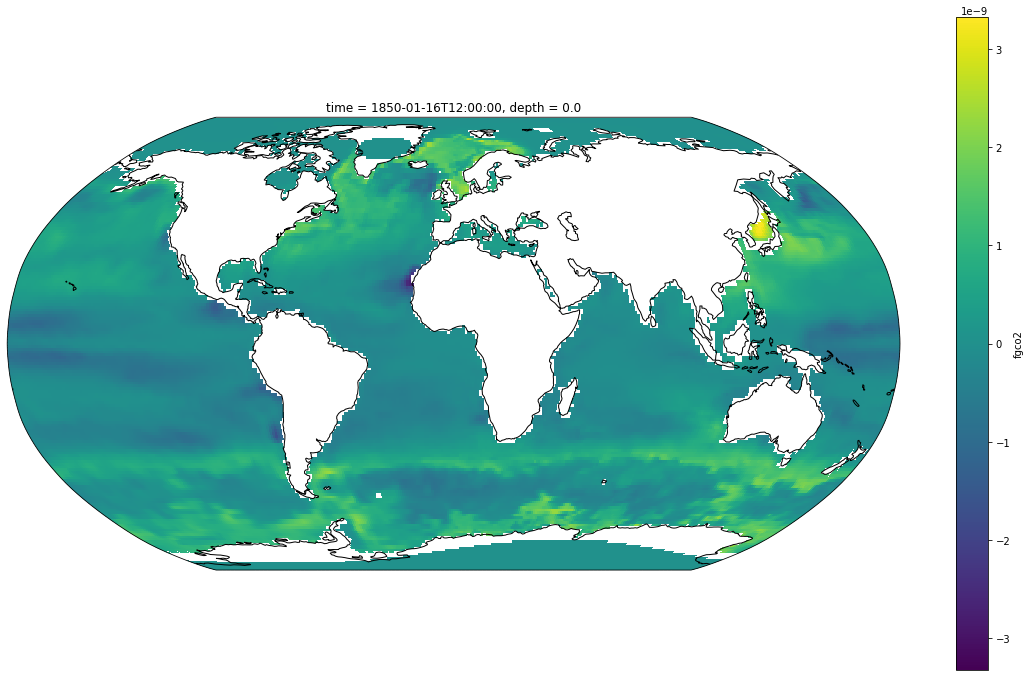

In [22]:
plt.figure(figsize=(20, 12))
ax = plt.axes(projection=ccrs.Robinson())
xrds_out.fgco2[0].plot.pcolormesh(transform=ccrs.PlateCarree(), cmap="viridis")
ax.coastlines()

### Masking on Antarctica and Greenland (near poles) is lost.

# 3. Nearest neighbour in iris.analysis.cartography.project
Fine for plotting but not usable for computing statistics!

In [ ]:
import iris.analysis.cartography

target_proj = ccrs.PlateCarree()
projected, extent = iris.analysis.cartography.project(cube, target_proj,
                                                         nx=360, ny=180)

#plt.gca().coastlines()

In [ ]:
plt.figure(figsize=(20, 12))
plt.axes(projection=ccrs.Robinson(0))
qplt.pcolormesh(projected[0])
plt.gca().coastlines()

# Playing with the data:

In [69]:
projected.coords()

[DimCoord(array([  15.5,   45. ,   74.5,  105. ,  135.5,  166. ,  196.5,  227.5,
         258. ,  288.5,  319. ,  349.5,  380.5,  410. ,  439.5,  470. ,
         500.5,  531. ,  561.5,  592.5,  623. ,  653.5,  684. ,  714.5,
         745.5,  775.5,  805.5,  836. ,  866.5,  897. ,  927.5,  958.5,
         989. , 1019.5, 1050. , 1080.5, 1111.5, 1141. , 1170.5, 1201. ,
        1231.5, 1262. , 1292.5, 1323.5, 1354. , 1384.5, 1415. , 1445.5,
        1476.5, 1506. , 1535.5, 1566. , 1596.5, 1627. , 1657.5, 1688.5,
        1719. , 1749.5, 1780. , 1810.5, 1841.5, 1871. , 1900.5, 1931. ,
        1961.5, 1992. , 2022.5, 2053.5, 2084. , 2114.5, 2145. , 2175.5,
        2206.5, 2236.5, 2266.5, 2297. , 2327.5, 2358. , 2388.5, 2419.5,
        2450. , 2480.5, 2511. , 2541.5, 2572.5, 2602. , 2631.5, 2662. ,
        2692.5, 2723. , 2753.5, 2784.5, 2815. , 2845.5, 2876. , 2906.5,
        2937.5, 2967. , 2996.5, 3027. , 3057.5, 3088. , 3118.5, 3149.5,
        3180. , 3210.5, 3241. , 3271.5, 3302.5, 3332. ,

In [67]:
regridder.weights.data

Format,coo
Data Type,float64
Shape,"(64800, 56320)"
nnz,241360
Density,6.613443462401796e-05
Read-only,True
Size,3.7M
Storage ratio,0.0


In [46]:
xrds['fgco2'].values.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [47]:
cube.data.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : False
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [56]:
iris.analysis.maths.apply_ufunc(xe.Regridder.regrid_array, cube, regridder.weights.data)

TypeError: regrid_array is not recognised, it is not an instance of numpy.ufunc

In [58]:
xe.Regridder.regrid_array

<function xesmf.frontend.BaseRegridder.regrid_array(self, indata, weights, skipna=False, na_thres=1.0)>

In [69]:
regridder.regrid_array(cube.data, regridder.weights.data)

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        ...,
        [9.05452768e-10, 1.20596566e-09, 4.11987278e-10, ...,
         7.96085281e-11, 2.16939536e-10, 3.14659215e-10],
        [4.28082188e-11, 5.00340186e-11, 6.15878321e-11, ...,
         2.14197422e+19, 1.90591154e-11, 2.66892272e-11],
        [1.19843432e-11, 1.30911896e-11, 1.50804022e-11, ...,
         1.14140479e-12, 4.52321730e-12, 7.67735962e-12]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 

In [64]:
cube.data.fill_value

0.0

In [79]:
xcoord = cube.coord(axis="x")

In [80]:
cube.coord_dims(xcoord)

(1, 2)

In [90]:
cube_out.coord(axis="x").shape

(72,)

In [143]:
xrds.nbytes/1024/1024

58.445091247558594